In [1]:
# Project - Classification 
# 1. Binary Classification, 2. Multiclass Classification
# 3. Multi-Level classification 4. Multi-output classification
# Data - MNIST data
# Data Description
    # 70,000 small Images
    # 784 features
    # Each Image size 28 * 28 pixels 
    # Pixel Intensity 0 to 255
##########################################

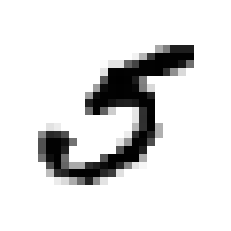

In [2]:
##########################----Import Library
import numpy as np
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
###########################----Download Data
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
#
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
############################----display 5
mnist.data.shape
X, y = mnist["data"], mnist["target"]
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()


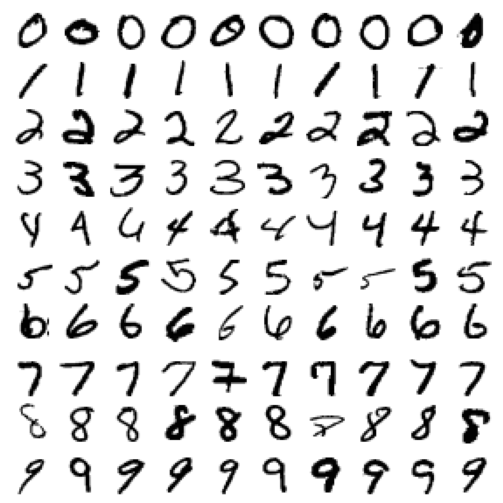

In [3]:
####################-----Display total image
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
#
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
#
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [4]:
###############----------Train Test Split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
###############----------Binary Classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
#
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)
#
sgd_clf.predict([some_digit])
####-----------------------cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
#
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
#
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
###-----------------------cross validation predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
###------------------------confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)
###-------------------------Precision, Recall and F1-Score
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
#
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
#
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
#
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
#
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

0.9686
0.96205
0.9668


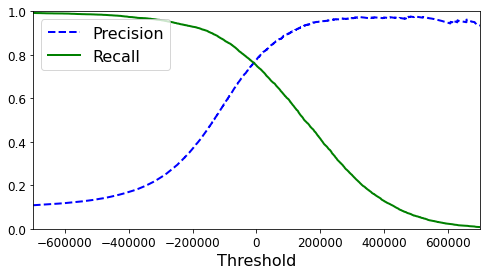

In [6]:
############---------Precision-Recall Vs Threshold Curve ----------------------
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [7]:
(y_train_pred == (y_scores > 0)).all()
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

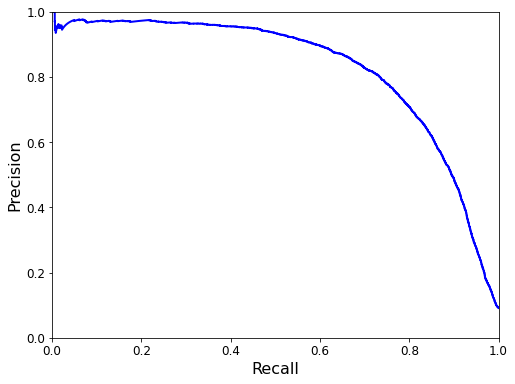

In [8]:
############------------Precision Vs Recall Curve
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

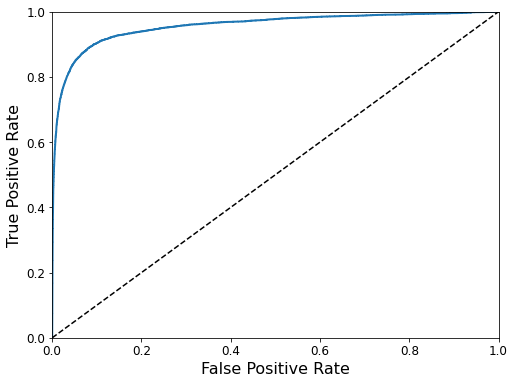

In [9]:
###############-----ROC Curve---------------
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

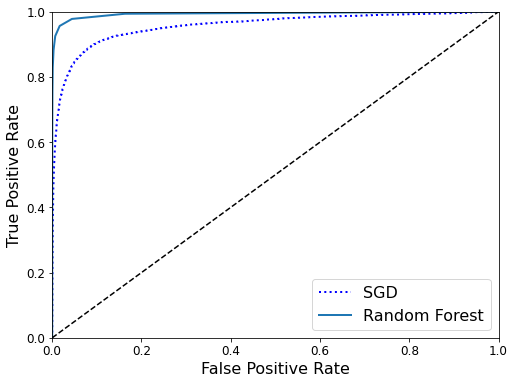

In [11]:
############----------Random Forest Classifier--------
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
#
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [12]:
# ROC, AUC score
roc_auc_score(y_train_5, y_scores_forest)
#
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)
#
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

In [13]:
############-------Multiclass Classification------------
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
#
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores
#
np.argmax(some_digit_scores)
#
sgd_clf.classes_
#
sgd_clf.classes_[5]
#
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
#
len(ovo_clf.estimators_)
#
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
#
forest_clf.predict_proba([some_digit])
#
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
#
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]],
      dtype=int64)

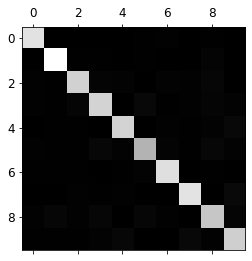

In [14]:
##-- Confusion matrix plot
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
#
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

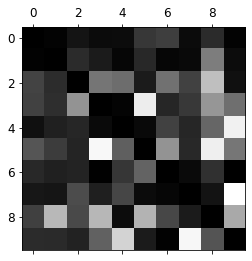

In [15]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

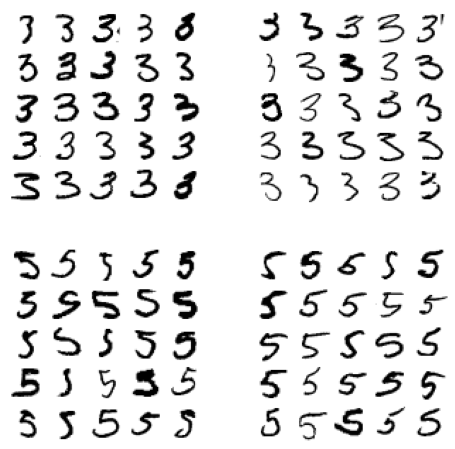

In [16]:
####---Error analysis digit plot-----
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [17]:
##############-----------Multilabel classification----------------
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
#
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
#
knn_clf.predict([some_digit])
#
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


0.97709078477525

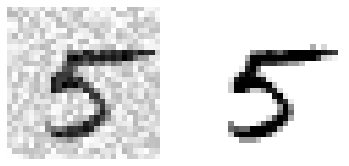

In [18]:
###---------------Multioutput classification ---------------------
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
#
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

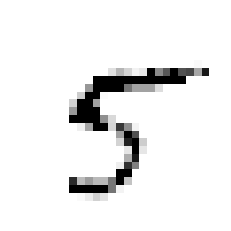

In [19]:
###----cleaned digit
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)